<a href="https://colab.research.google.com/github/calamistratus/Whales_project/blob/main/Image_regularizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from PIL import Image
from IPython.display import clear_output

In [ ]:
path = ''

train = pd.read_csv(path + 'train.csv')

im_paths = {'train' : path + 'train/',
            'test' : path + 'test/'}

dirlists = {'train' : np.array(os.listdir(path + 'train')),
            'test' : np.array(os.listdir(path + 'test'))}

In [ ]:
train.sample(5)

,Image,Id
8740,e39272cf.jpg,w_8ddc642
7412,c018a6ac.jpg,w_abe383e
8405,dab5a0c7.jpg,w_0654dd9
1624,2b00cd74.jpg,w_b4732ef
901,16812a1e.jpg,w_8201aa8


In [ ]:
train['Id'].value_counts()

Id
new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
            ... 
w_5dcbb74      1
w_bbcafb8      1
w_f400702      1
w_07a425f      1
w_0e4ef50      1
Name: count, Length: 4251, dtype: int64

## DataFrame analysis

The DataFrame given only provides unique Ids of whales and a filename of a .jpg picture of its fluke.

810 whales are new, that comes to 8 % of the train DataFrame.




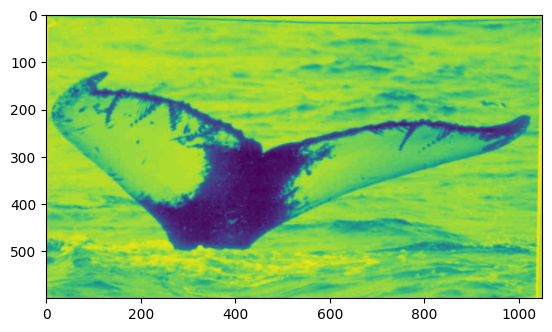

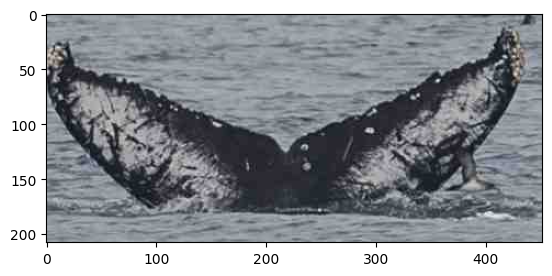

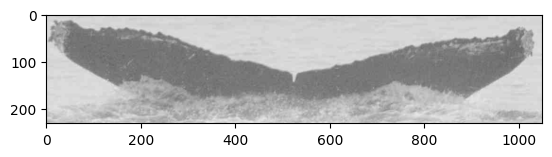

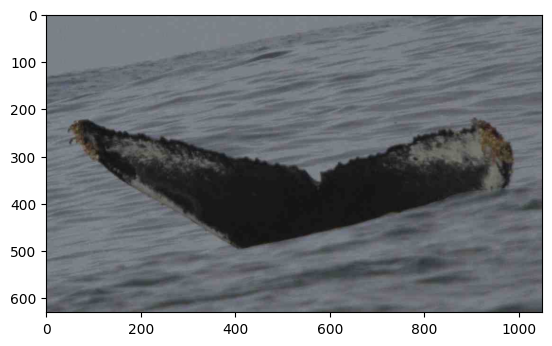

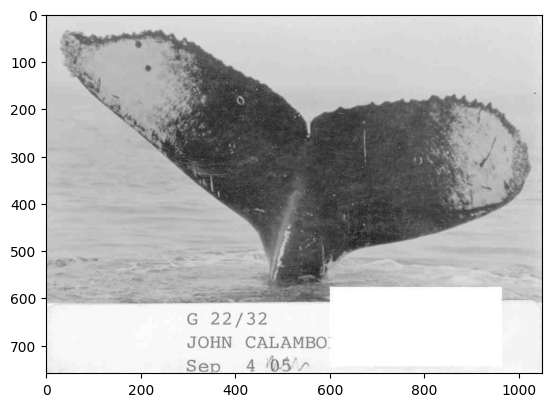

In [ ]:
sample_num = 5

for i in np.random.choice(dirlists['train'], sample_num):
  pic = Image.open(im_paths['train'] + i)

  plt.imshow(pic)
  plt.show()

# Naked-eye picture analysis

As we can see in the picture sample above, the pictues differ from one another in their format, size and colour.

It will be quite a task to regularize them into the same format.

Things to consider:

1. Many images have a horizon line on top, so adding it on other would bring no issue.
2. Picture differ in colour format, size and ratio.
3. Many pictures have data beneath them. That could either improve the model or poison it.
4. Some pictures are turned to the side, but that shouldn't be that significant.
5. Flukes themselves are black and white, so the pictures can be freely turned into grayscale.

In [ ]:
sizes = []
iteration = 0
sample_num = 3000

for filename in np.random.choice(dirlists['train'], sample_num):
  iteration += 1
  print('\r', round(iteration/sample_num*100), '% done', end='')

  pic = Image.open(im_paths['train'] + filename)
  sizes.append(list(pic.size))   # Getting an array of picture sizes
clear_output()

In [ ]:
sizes = pd.DataFrame(np.asarray(sizes))
sizes.columns = ['h', 'w']
sizes.describe()    # The size of pictures will be the mean size, so (1000, 500) with an aspect ration of 2:1
# On further thinking, i reduced the size to (200, 100) because the time spent was ubearable

,h,w
count,3000.00000,3000.000000
mean,966.88700,474.728667
std,158.23341,163.462227
min,64.00000,30.000000
25%,973.00000,345.000000
50%,1050.00000,464.000000
75%,1050.00000,600.000000
max,1050.00000,1575.000000


In [ ]:
def regularize(picture):
  picture = picture.convert('L')    # Converting image into grayscale

  size = list(picture.size)

  if size[1] < size[0] // 2:    # If the image is wider than it should be
    size[1] = int(np.ceil(size[0] // 2)) +  picture.size[0] % 2

    layer = Image.new('L', (size[0] + picture.size[0] % 2, size[1]), (255))
    layer.paste(picture, (0, size[1] -  picture.size[1]))
    picture = layer
    # White background similiar to sky is added, the images cannot be cropped horizontaly because that would cut off fin sides

  else:   # If the image is thinner than it should be
    half_difference = (size[1] - size[0] // 2) / 2
    picture = picture.crop((size[0] % 2, np.ceil(half_difference), size[0], size[1] - np.floor(half_difference)))
    # The image is cropped vertically from both sides. The fins are mostly horizontal so that shouldn't be an issue

  return picture.resize((200, 100))

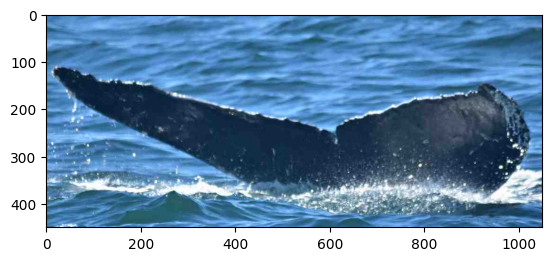

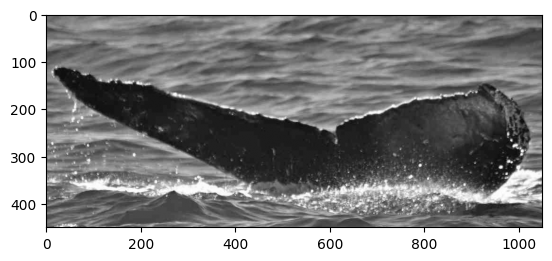

Original size: (1050, 450)
1:2 ratio is True
New size: (200, 100)


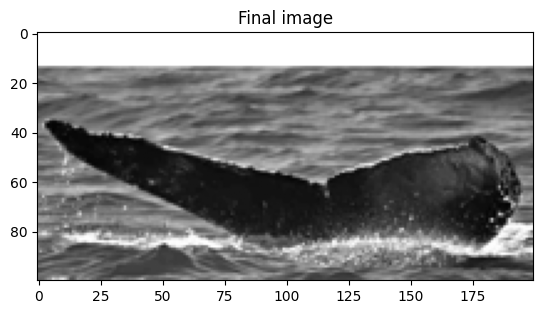

In [ ]:
pic = Image.open(im_paths['train'] + np.random.choice(dirlists['train'], 1)[0])    # A random image

plt.imshow(pic)
plt.show()

plt.imshow(pic.convert('L'), cmap='gray')    # Converting into grayscale
plt.show()

new_pic = regularize(pic)

print('Original size:', pic.size)
print('1:2 ratio is', new_pic.size[1] * 2 == new_pic.size[0])
print('New size:', new_pic.size)

plt.imshow(new_pic, cmap='gray')
plt.title('Final image')
plt.show()

In [ ]:
saving_path = path    # Change if needed

reg_im_paths = {'train' : saving_path + 'regularized_images_train/',
                'test' : saving_path + 'regularized_images_test/'}

for directory_path in reg_im_paths.values():
    if not os.path.isdir(directory_path):
        os.mkdir(directory_path)

In [ ]:
for dataset_type in ['train', 'test']:    # Used to fill 2 folders with regularized pictures
    length = len(dirlists[dataset_type])
    iteration = 0

    for filename in dirlists[dataset_type]:
        iteration += 1
        print('\r', round(iteration / length * 100), f'% done in {dataset_type} directory'.ljust(100), end='', flush=True)

        pic = Image.open(im_paths[dataset_type] + filename)
        pic = regularize(pic)
        pic.save(reg_im_paths[dataset_type] + filename)
clear_output()

In [ ]:
train_pic_arrays = {'train' : [],
                    'test' : []}

for dataset_type in ['train', 'test']:    # Used to transform 2 folders into nparrays
    length = len(dirlists[dataset_type])    # Same names, different directories
    iteration = 0

    for filename in dirlists[dataset_type]:
        iteration += 1
        print('\r', round(iteration / length * 100), f'% done in {dataset_type} directory'.ljust(100), end='', flush=True)

        pic = Image.open(reg_im_paths[dataset_type] + filename)
        pic = np.asarray(pic)

        train_pic_arrays[dataset_type].append(pic)

    np.save(saving_path + dataset_type + '_array',  np.asarray(train_pic_arrays[dataset_type]).reshape(len(dirlists[dataset_type]), -1))
    train_pic_arrays[dataset_type] = 0
clear_output()